In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
# from snowflake.connector.pandas_tools import write_pandas
# from sqlalchemy import create_engine
import snowflake.connector

from mplsoccer import Pitch, VerticalPitch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math

from snowflake.connector.pandas_tools import write_pandas

d:\Users\ksbha\miniconda3\envs\footy\Lib\site-packages\snowflake\connector\options.py:103: UserWarning: You have an incompatible version of 'pyarrow' installed (14.0.2), please install a version that adheres to: 'pyarrow<10.1.0,>=10.0.1; extra == "pandas"'
  warn_incompatible_dep(
Failed to import ArrowResult. No Apache Arrow result set format can be used. ImportError: DLL load failed while importing arrow_iterator: The specified procedure could not be found.


In [2]:
import snowflake.connector

In [3]:
## Set options to view all columns
pd.set_option('display.max_columns', None)

In [4]:
SNOWFLAKE_USER = 'kbharaj3'
SNOWFLAKE_PASSWORD = 'Snowfl@key0014'
SNOWFLAKE_ACCOUNT = 'qx25653.ca-central-1.aws'
SNOWFLAKE_WAREHOUSE = 'FOOTY_STORE'
SNOWFLAKE_DATABASE = 'GEGENSTATS'
SNOWFLAKE_SCHEMA = 'TABLES'

In [5]:
conn = snowflake.connector.connect(
    user=SNOWFLAKE_USER,
    password=SNOWFLAKE_PASSWORD,
    account=SNOWFLAKE_ACCOUNT,
    warehouse=SNOWFLAKE_WAREHOUSE,
    database=SNOWFLAKE_DATABASE,
    schema=SNOWFLAKE_SCHEMA
)

In [6]:
cursor = conn.cursor()

In [7]:
def fetch_data(cursor, query):
    cursor.execute(query)
    rows = cursor.fetchall()
    column_names = [desc[0] for desc in cursor.description]
    return pd.DataFrame(rows, columns=column_names)

In [8]:
team_names = fetch_data(cursor, 'SELECT * FROM TEAMS')

In [9]:
team_misc = fetch_data(cursor, 'SELECT * FROM TEAM_MISC_STATS')

In [10]:
team_standard = fetch_data(cursor, 'SELECT * FROM TEAM_STANDARD_STATS')

In [11]:
team_attacking = fetch_data(cursor, 'SELECT * FROM TEAM_ATTACKING_STATS')

In [12]:
team_defending = fetch_data(cursor, 'SELECT * FROM TEAM_DEFENDING_STATS')

In [13]:
df_competitions = fetch_data(cursor, 'SELECT COMPETITION, COMPETITION_ACRONYM, SEASON FROM COMPETITIONS')

In [14]:
df_matches = fetch_data(cursor, 'SELECT * FROM MATCHES')

In [15]:
df_shots = fetch_data(cursor, 'SELECT * FROM SHOT_EVENTS')

In [16]:
team_misc = team_misc.merge(df_competitions, on=['COMPETITION','SEASON'], how='left')

team_misc = team_misc.merge(team_names, on='TEAM_FBREF_ID', how='left')

team_misc = team_misc.merge(team_standard, on=['TEAM_FBREF_ID', 'SEASON', 'COMPETITION'], how='left')

In [17]:
df_competitions.head()

,COMPETITION,COMPETITION_ACRONYM,SEASON
0,ENG-Premier League,EPL,2122
1,ENG-Premier League,EPL,2324
2,ENG-Premier League,EPL,2223


In [18]:
team_misc['AERIAL DUELS WON RATIO (%)'] = team_misc['AERIALS_WON']*100/(team_misc['AERIALS_WON'] + 
                                                                team_misc['AERIALS_LOST'])
team_misc['AERIAL DUELS ATTEMPTED PER GAME'] = (team_misc['AERIALS_WON'] + 
                                           team_misc['AERIALS_LOST'])/team_misc['MATCHES_PLAYED']

In [19]:
x_min_aerial = (team_misc['AERIAL DUELS WON RATIO (%)'].min() // 5)*5
x_max_aerial = (team_misc['AERIAL DUELS WON RATIO (%)'].max()//5)*5 + 5
y_min_aerial = (team_misc['AERIAL DUELS ATTEMPTED PER GAME'].min()//5)*5
y_max_aerial = (team_misc['AERIAL DUELS ATTEMPTED PER GAME'].max()//5)*5 + 5

In [20]:
## Old limits: (45.0, 60.0, 20.0, 35.0)

In [21]:
team_goal_output = team_standard.merge(team_defending[['TEAM_FBREF_ID', 'SEASON', 'COMPETITION', 'XG_AGAINST']], 
                                       on=['TEAM_FBREF_ID', 'SEASON', 'COMPETITION'], how='left')

team_goal_output = team_goal_output.merge(df_competitions[['COMPETITION','COMPETITION_ACRONYM','SEASON']], 
                                      on=['COMPETITION','SEASON'], how='left')

team_goal_output = team_goal_output.merge(team_attacking[['TEAM_FBREF_ID', 'SEASON', 'COMPETITION','NPXG']], 
                                          on=['TEAM_FBREF_ID', 'SEASON', 'COMPETITION'], how='left')

In [22]:
team_goal_output['EXPECTED GOALS AGAINST PER GAME'] = team_goal_output['XG_AGAINST']/team_goal_output['MATCHES_PLAYED']
team_goal_output['NON PENALTY EXPECTED GOALS PER GAME'] = team_goal_output['NPXG']/team_goal_output['MATCHES_PLAYED']

In [23]:
team_goal_output = team_goal_output.merge(team_names, on='TEAM_FBREF_ID', how='left')

In [24]:
x_min_goal_output = 0.45
x_max_goal_output = 2.60
y_min_goal_output = 0.5
y_max_goal_output = 2.40

In [25]:
team_defending['BLOCKS'] = team_defending['BLOCKED_SHOTS'] + team_defending['BLOCKED_PASSES']

In [26]:
team_defending_chart = team_standard.merge(team_defending[['TEAM_FBREF_ID', 'SEASON', 'COMPETITION', 'BLOCKS', 'CLEARANCES',
                                                           'GOALS_CONCEDED', 'SHOTS_FACED', 'TACKLES', 'TACKLES_WON']], 
                                       on=['TEAM_FBREF_ID', 'SEASON', 'COMPETITION'], how='left')

team_defending_chart = team_defending_chart.merge(df_competitions[['COMPETITION','COMPETITION_ACRONYM','SEASON']], 
                                      on=['COMPETITION','SEASON'], how='left')

team_defending_chart = team_defending_chart.merge(team_names, on='TEAM_FBREF_ID', how='left')

In [27]:
team_defending_chart['BLOCKS PER GAME'] = team_defending_chart['BLOCKS']/team_defending_chart['MATCHES_PLAYED']
team_defending_chart['CLEARANCES PER GAME'] = team_defending_chart['CLEARANCES']/team_defending_chart['MATCHES_PLAYED']
team_defending_chart['SHOTS FACED PER GAME'] = team_defending_chart['SHOTS_FACED']/team_defending_chart['MATCHES_PLAYED']
team_defending_chart['OPPOSITION CONVERSION RATE (%)'] = (team_defending_chart['GOALS_CONCEDED']/team_defending_chart['SHOTS_FACED'])*100
team_defending_chart['CONCEDED PER GAME'] = team_defending_chart['GOALS_CONCEDED']/team_defending_chart['MATCHES_PLAYED']
team_defending_chart['TACKLES ATTEMPTED PER GAME'] = team_defending_chart['TACKLES']/team_defending_chart['MATCHES_PLAYED']
team_defending_chart['TACKLES WON RATIO (%)'] = (team_defending_chart['TACKLES_WON']/team_defending_chart['TACKLES'])*100

In [28]:
SNOWFLAKE_SCHEMA = 'RADAR_CHARTS'

In [29]:
conn = snowflake.connector.connect(
    user=SNOWFLAKE_USER,
    password=SNOWFLAKE_PASSWORD,
    account=SNOWFLAKE_ACCOUNT,
    warehouse=SNOWFLAKE_WAREHOUSE,
    database=SNOWFLAKE_DATABASE,
    schema=SNOWFLAKE_SCHEMA
    )

In [30]:
cur = conn.cursor()
cur.execute(f"USE WAREHOUSE {SNOWFLAKE_WAREHOUSE}")

In [31]:
create_schema_sql = f"CREATE SCHEMA IF NOT EXISTS {SNOWFLAKE_SCHEMA}"
cur.execute(create_schema_sql)

In [32]:
create_table_query = """
CREATE TABLE IF NOT EXISTS TEAM_GOAL_OUTPUT (
    SEASON INT,
    COMPETITION_ACRONYM VARCHAR(255),
    TEAM_NAME VARCHAR(255),
    TEAM_LOGO_URL VARCHAR(255),
    EXPECTED_GOALS_AGAINST_PER_GAME FLOAT,
    NON_PENALTY_EXPECTED_GOALS_PER_GAME FLOAT,
    PRIMARY KEY (SEASON, COMPETITION_ACRONYM, TEAM_NAME)
);
"""

In [33]:
cur.execute(create_table_query)

In [34]:
create_table_query = """
CREATE TABLE IF NOT EXISTS TEAM_DEFENDING_CHART (
    SEASON INT,
    COMPETITION_ACRONYM VARCHAR(255),
    TEAM_NAME VARCHAR(255),
    TEAM_LOGO_URL VARCHAR(255),
    BLOCKS_PER_GAME FLOAT,
    CLEARANCES_PER_GAME FLOAT,
    SHOTS_FACED_PER_GAME FLOAT,
    OPPOSITION_CONVERSION_RATE FLOAT,
    CONCEDED_PER_GAME FLOAT,
    TACKLES_ATTEMPTED_PER_GAME FLOAT,
    TACKLES_WON_RATIO FLOAT,
    PRIMARY KEY (SEASON, COMPETITION_ACRONYM, TEAM_NAME)
);
"""

In [74]:
cur.execute(create_table_query)

In [37]:
def upsert_to_snowflake(table_name, dataframe, primary_keys):
    if isinstance(primary_keys, str):
        primary_keys = [primary_keys]

    temp_table_name = f"{table_name}_TEMP"
    success, nchunks, nrows, _ = write_pandas(conn, dataframe, temp_table_name, auto_create_table=True)

    on_condition = ' AND '.join([f"{table_name}.{pk} = {temp_table_name}.{pk}" for pk in primary_keys])

    update_columns = [col for col in dataframe.columns if col not in primary_keys]
    update_sql = ', '.join([f"{table_name}.{col} = {temp_table_name}.{col}" for col in update_columns])

    merge_sql = f"""
    MERGE INTO {table_name} USING {temp_table_name}
    ON {on_condition}
    """

    if update_columns:
        merge_sql += f"""
        WHEN MATCHED THEN
            UPDATE SET
                {update_sql}
        """

    merge_sql += f"""
    WHEN NOT MATCHED THEN
        INSERT ({', '.join(dataframe.columns)})
        VALUES ({', '.join([f"{temp_table_name}.{col}" for col in dataframe.columns])})
    """

    cur.execute(merge_sql)
    cur.execute(f"DROP TABLE IF EXISTS {temp_table_name}")

    print(f"Upsert completed. {nrows} rows processed.")

In [35]:
team_goal_output.rename(columns={'EXPECTED GOALS AGAINST PER GAME':'EXPECTED_GOALS_AGAINST_PER_GAME',
                                 'NON PENALTY EXPECTED GOALS PER GAME':'NON_PENALTY_EXPECTED_GOALS_PER_GAME'}, inplace=True)

In [38]:
upsert_to_snowflake("TEAM_GOAL_OUTPUT", team_goal_output[['SEASON', 'COMPETITION_ACRONYM', 'TEAM_NAME', 'TEAM_LOGO_URL',
                    'EXPECTED_GOALS_AGAINST_PER_GAME', 'NON_PENALTY_EXPECTED_GOALS_PER_GAME']],
                    ['SEASON', 'COMPETITION_ACRONYM', 'TEAM_NAME'])

Upsert completed. 60 rows processed.


In [39]:
team_defending_chart.columns = team_defending_chart.columns.str.replace(" ", "_")

In [40]:
team_defending_chart.rename(columns={'TACKLES_WON_RATIO_(%)':'TACKLES_WON_RATIO',
                                     'OPPOSITION_CONVERSION_RATE_(%)':'OPPOSITION_CONVERSION_RATE'}, inplace=True)

In [41]:
upsert_to_snowflake("TEAM_DEFENDING_CHART", team_defending_chart[['SEASON', 'COMPETITION_ACRONYM', 'TEAM_NAME', 'TEAM_LOGO_URL',
                    'BLOCKS_PER_GAME', 'CLEARANCES_PER_GAME', 'SHOTS_FACED_PER_GAME', 'OPPOSITION_CONVERSION_RATE',
                    'CONCEDED_PER_GAME', 'TACKLES_ATTEMPTED_PER_GAME', 'TACKLES_WON_RATIO']],
                    ['SEASON', 'COMPETITION_ACRONYM', 'TEAM_NAME'])

Upsert completed. 60 rows processed.


In [42]:
SNOWFLAKE_SCHEMA

'RADAR_CHARTS'

In [43]:
cur = conn.cursor()

In [44]:
team_defending_chart = fetch_data(cursor, 'SELECT * FROM GEGENSTATS.RADAR_CHARTS.TEAM_DEFENDING_CHART')

In [45]:
team_goal_output = fetch_data(cursor, 'SELECT * FROM GEGENSTATS.RADAR_CHARTS.TEAM_GOAL_OUTPUT')

In [46]:
team_defending_chart.rename(columns={'BLOCKS_PER_GAME':'BLOCKS PER GAME', 'CLEARANCES_PER_GAME':'CLEARANCES PER GAME',
                                    'SHOTS_FACED_PER_GAME':'SHOTS FACED PER GAME', 'OPPOSITION_CONVERSION_RATE':'OPPOSITION CONVERSION RATE (%)',
                                    'CONCEDED_PER_GAME':'CONCEDED PER GAME', 'TACKLES_ATTEMPTED_PER_GAME':'TACKLES ATTEMPTED PER GAME',
                                    'TACKLES_WON_RATIO':'TACKLES WON RATIO (%)'}, inplace=True)

In [47]:
team_goal_output.rename(columns={'EXPECTED_GOALS_AGAINST_PER_GAME':'EXPECTED GOALS AGAINST PER GAME',
                                'NON_PENALTY_EXPECTED_GOALS_PER_GAME':'NON PENALTY EXPECTED GOALS PER GAME'}, inplace=True)

In [48]:
def create_FM_team_scatter_chart(df, chart_name, team_name, x_axis_label, y_axis_label, img_size, x_min, x_max, y_min, y_max, bottom_left_label, 
                                 bottom_right_label, top_left_label, top_right_label, bl_color, br_color, tl_color, tr_color):
    fig = go.Figure()
    x_axis_mean_val = df[x_axis_label].mean()
    y_axis_mean_val = df[y_axis_label].mean()

    # Add the scatter plot points
    for index, row in df.iterrows():
        fig.add_trace(go.Scatter(
            x=[row[x_axis_label]],
            y=[row[y_axis_label]],
            mode='markers',
            text=row["TEAM_NAME"],
            marker=dict(
                opacity=0
            ),
            hoverinfo='text',
        ))

        # Add team logo as a layout_image
        fig.add_layout_image(
            dict(
                source=row["TEAM_LOGO_URL"],
                x=row[x_axis_label],
                y=row[y_axis_label],
                xref="x",
                yref="y",
                xanchor="center",
                yanchor="middle"
            )
        )


    # Update axes and layout as necessary
    # ...
        
    fig.update_xaxes(range=[x_min, x_max], title=x_axis_label)
    fig.update_yaxes(range=[y_min, y_max], title=y_axis_label)

    fig.add_shape(
        type='line',
        x0=x_axis_mean_val, y0=fig.layout.yaxis.range[0],  # start of the line
        x1=x_axis_mean_val, y1=fig.layout.yaxis.range[1],  # end of the line
        line=dict(color='White', width=3),
        layer='below'
    )

    # Add a horizontal line at the mean aerials attempted per game
    fig.add_shape(
        type='line',
        x0=fig.layout.xaxis.range[0], y0=y_axis_mean_val,  # start of the line
        x1=fig.layout.xaxis.range[1], y1=y_axis_mean_val,  # end of the line
        line=dict(color='White', width=3),
        layer='below'
    )

    fig.update_layout(
        width=625,
        height=625,
        showlegend=False,
        paper_bgcolor='rgb(70, 70, 70)',
        plot_bgcolor='rgb(70, 70, 70)',
        font=dict(
                family="Roboto, sans-serif",  # Specify the font family
                size=25,                     # Specify the font size
                color="white"                # Specify the font color
            ),
        hoverlabel=dict(
                bgcolor="rgba(20, 20, 20, 0.8)",
                font_family="Roboto, sans-serif"),
        title={
            'text': f'{chart_name}',
            'y':0.98,  # Sets the y position of the title (1 is the top of the figure)
            'x':0.5,  # Centers the title horizontally (0.5 is the center of the figure)
            'xanchor': 'center',  # Ensures the title is centered at the x position
            'yanchor': 'top',  # Ensures the title is at the top of the y position
            'font': dict(
                family="Roboto, sans-serif",  # Specify the font family
                size=23,                     # Specify the font size
                color="white"                # Specify the font color
            )
        },
        margin=dict(l=10, r=30, t=50, b=10),
        images= [dict(
            source= row["TEAM_LOGO_URL"],
            xref="x",
            yref="y",
            x= row[x_axis_label],
            y= row[y_axis_label],
            sizex=img_size*1.8 if row['TEAM_NAME'] == team_name else img_size,  # The size of the image in x axis units
            sizey=img_size*1.8 if row['TEAM_NAME'] == team_name else img_size,  # The size of the image in y axis units
            sizing="contain",
            opacity=1 if row['TEAM_NAME'] == team_name else 0.35,
            layer="above") for index, row in df.iterrows()]
    )

    fig.update_xaxes(
        title=dict(font=dict(size=25)),
        showline=True,  # Show the axis line
        linewidth=2,  # Width of the axis line
        linecolor='white',  # Color of the axis line
        gridcolor='rgba(0,0,0,0)',  # Set grid line color to transparent
        tickfont=dict(color='white', size=15),  # Set the color of the axis ticks (numbers)
    )

    fig.update_yaxes(
        title=dict(font=dict(size=25)),
        showline=True,
        linewidth=2,
        linecolor='white',
        gridcolor='rgba(0,0,0,0)',
        tickfont=dict(color='white', size=15),
    )

    fig.add_annotation(text=bottom_left_label,
                    xref="paper", yref="paper",
                    x=0, y=0,  # Bottom left corner
                    showarrow=False,
                    font=dict(size=15, color=bl_color, family="Roboto, sans-serif"),
                    align="left")

    fig.add_annotation(text=top_left_label,
                    xref="paper", yref="paper",
                    x=0, y=1,  # Top left corner
                    showarrow=False,
                    font=dict(size=15, color=tl_color, family="Roboto, sans-serif"),
                    align="left")

    fig.add_annotation(text=top_right_label,
                    xref="paper", yref="paper",
                    x=1, y=1,  # Top right corner
                    showarrow=False,
                    font=dict(size=15, color=tr_color, family="Roboto, sans-serif"),
                    align="right")

    fig.add_annotation(text=bottom_right_label,
                    xref="paper", yref="paper",
                    x=1, y=0,  # Bottom right corner
                    showarrow=False,
                    font=dict(size=15, color=br_color, family="Roboto, sans-serif"),
                    align="right")

    return fig

In [49]:
league_selected = 'EPL'
season_selected = 2324

In [50]:
filtered_team_misc = team_misc[team_misc['SEASON'] == season_selected]
filtered_team_misc = filtered_team_misc[filtered_team_misc['COMPETITION_ACRONYM'] == league_selected]
filtered_team_goal_output = team_goal_output[team_goal_output['SEASON'] == season_selected]
filtered_team_goal_output = filtered_team_goal_output[filtered_team_goal_output['COMPETITION_ACRONYM'] == league_selected]
filtered_team_defending_chart = team_defending_chart[team_defending_chart['SEASON'] == season_selected]
filtered_team_defending_chart = filtered_team_defending_chart[filtered_team_defending_chart['COMPETITION_ACRONYM'] == league_selected]

filtered_matches = df_matches[df_matches['SEASON'] == season_selected]

In [51]:
create_FM_team_scatter_chart(filtered_team_misc, 'AERIAL', "Arsenal", 'AERIAL DUELS WON RATIO (%)', 'AERIAL DUELS ATTEMPTED PER GAME', 
                                                            1.45, x_min_aerial, x_max_aerial, y_min_aerial, y_max_aerial, 
                                                            "Fewer Duels<br>Poor Dueling", "Fewer Duels<br>Strong Dueling",
                                                            "Lots of Duels<br>Poor Dueling", "Lots of Duels<br>Strong Dueling", "red", 
                                                            "orange", "orange", "green")

In [52]:
create_FM_team_scatter_chart(filtered_team_goal_output, 'GOAL OUTPUT', "Arsenal", 'EXPECTED GOALS AGAINST PER GAME', 'NON PENALTY EXPECTED GOALS PER GAME', 
                            0.1, x_min_goal_output, x_max_goal_output, y_min_goal_output, y_max_goal_output, 
                            "Low non-penalty expected goals<br>Strong Defending", "Low non-penalty expected goals<br>Poor Defending",
                            "High non-penalty expected goals<br>Strong Defending", "High non-penalty expected goals<br>Poor Defending", 
                            "orange", "red", "green", "orange")

In [53]:
create_FM_team_scatter_chart(filtered_team_defending_chart, 'DEFENDING', "Arsenal", 'CLEARANCES PER GAME', 'BLOCKS PER GAME', 
                            0.65, 10, 26, 7.5, 13.5, 
                            "Fewer blocks<br>Fewer Clearances", "Fewer blocks<br>Lots of Clearances",
                            "Lots of blocks<br>Fewer Clearances", "Fewer blocks<br>Lots of Clearances", 
                            "red", "orange", "orange", "green")

In [54]:
create_FM_team_scatter_chart(filtered_team_defending_chart, 'DEFENSIVE EFFICIENCY', "Arsenal", 'OPPOSITION CONVERSION RATE (%)', 
                             'SHOTS FACED PER GAME', 0.65, 7.5, 18, 5.5, 17, 
                            # 0.85, 7, 30, 4, 18, 
                            "Quiet defence<br>Impenetrable defence", "Quiet defence<br>Leaky defence", 
                            "Busy defence<br>Impenetrable defence", "Busy defence<br>Leaky defence", 
                            "green", "orange", "orange", "red")

In [55]:
create_FM_team_scatter_chart(filtered_team_defending_chart, 'GOALKEEPING', "Arsenal", 'SHOTS FACED PER GAME', 
                             'CONCEDED PER GAME', 0.45, 6, 17, 0.5, 2.75,
                            "Impenetrable defence<br>Quiet defence", "Impenetrable defence<br>Busy defence", 
                            "Leaky defence<br>Quiet defence", "Leaky defence<br>Busy defence", 
                            "green", "orange", "orange", "red")

In [58]:
create_FM_team_scatter_chart(filtered_team_defending_chart, 'TACKLING', "Arsenal", 'TACKLES WON RATIO (%)', 'TACKLES ATTEMPTED PER GAME', 
                                                            0.6, 53, 68, 11, 21, 
                                                            "Fewer Duels<br>Poor Dueling", "Fewer Duels<br>Strong Dueling",
                                                            "Lots of Duels<br>Poor Dueling", "Lots of Duels<br>Strong Dueling", "red", 
                                                            "orange", "orange", "green")


### Time to incorporate event data for additional graphs

In [59]:
df_player_match = fetch_data(cursor, 'SELECT PLAYER_WS_ID, MATCH_ID, PLAYER_FBREF_NAME, \
                             STARTING_POSITION_WS FROM PLAYER_MATCH')

In [60]:
df_events = fetch_data(cursor, 'SELECT * FROM EVENTS_SPADL')

In [61]:
# df_events = df_events[df_events['MATCH_ID'].isin(list(filtered_matches.MATCH_ID))]

In [62]:
df_events = df_events.merge(df_matches[['MATCH_ID','COMPETITION','SEASON']], on='MATCH_ID', how='left')

In [63]:
defensive_events = df_events[df_events['TYPE_NAME'].isin(['tackle', 'foul', 'interception','clearance'])]

In [64]:
defensive_events = defensive_events.merge(team_names[['TEAM_NAME', 'TEAM_FBREF_ID']], on='TEAM_FBREF_ID')
defensive_events = defensive_events.merge(df_player_match, on=['PLAYER_WS_ID', 'MATCH_ID'])

In [65]:
interest_pos = ['DL', 'DC', 'DR']
defender_defend_actions = defensive_events[defensive_events['STARTING_POSITION_WS'].isin(interest_pos)]

In [66]:
grouped_def_action_team = defender_defend_actions[['TEAM_NAME','COMPETITION','SEASON',
                                                   'START_X']].groupby(['TEAM_NAME','COMPETITION','SEASON']).mean()

In [67]:
team_defending = team_defending.merge(team_names[['TEAM_NAME', 'TEAM_FBREF_ID', 'TEAM_LOGO_URL']], on='TEAM_FBREF_ID')

In [68]:
grouped_OPPDA = team_defending[['TEAM_NAME','TEAM_LOGO_URL','COMPETITION','SEASON',
                                'OPP_PPDA']].groupby(['COMPETITION','SEASON','TEAM_NAME','TEAM_LOGO_URL']).mean()

In [69]:
grouped_def_action_team.rename({'START_X':'AVERAGE DEFENSIVE ACTION FROM DEFENDERS (YARDS)'}, axis=1,inplace=True)

In [70]:
grouped_OPPDA = team_defending[['TEAM_NAME','TEAM_LOGO_URL','COMPETITION','SEASON','OPP_PPDA']].groupby(['TEAM_NAME',
                                                        'COMPETITION','SEASON','TEAM_LOGO_URL']).mean()
grouped_def_action_team.rename({'START_X':'AVERAGE DEFENSIVE ACTION FROM DEFENDERS (YARDS)'}, axis=1,inplace=True)
grouped_OPPDA.rename({'OPP_PPDA':'OPPOSITION PASSES PER DEFENSIVE ACTION'}, axis=1,inplace=True)
pressing_intensity_chart = pd.merge(grouped_def_action_team.reset_index(), grouped_OPPDA.reset_index(), on=['TEAM_NAME', 
                                                                            'COMPETITION','SEASON'])
pressing_intensity_chart.reset_index(inplace=True, drop=True)

In [71]:
pressing_intensity_chart = pressing_intensity_chart.merge(df_competitions, on=['COMPETITION','SEASON'])

In [72]:
pressing_intensity_chart.drop(['COMPETITION'], axis=1, inplace=True)

In [70]:
create_table_query = """
CREATE TABLE IF NOT EXISTS PRESSING_INTENSITY_CHART (
    SEASON INT,
    COMPETITION_ACRONYM VARCHAR(255),
    TEAM_NAME VARCHAR(255),
    TEAM_LOGO_URL VARCHAR(255),
    AVERAGE_DEFENSIVE_ACTION_FROM_DEFENDERS FLOAT,
    OPPOSITION_PASSES_PER_DEFENSIVE_ACTION FLOAT,
    PRIMARY KEY (SEASON, COMPETITION_ACRONYM, TEAM_NAME)
);
"""

In [71]:
cur.execute(create_table_query)

In [73]:
pressing_intensity_chart.columns = pressing_intensity_chart.columns.str.replace(" ", "_")

In [74]:
pressing_intensity_chart.rename(columns={'AVERAGE_DEFENSIVE_ACTION_FROM_DEFENDERS_(YARDS)':'AVERAGE_DEFENSIVE_ACTION_FROM_DEFENDERS'}, inplace=True)

In [75]:
upsert_to_snowflake("PRESSING_INTENSITY_CHART", pressing_intensity_chart[['SEASON', 'COMPETITION_ACRONYM', 'TEAM_NAME', 'TEAM_LOGO_URL',
                    'AVERAGE_DEFENSIVE_ACTION_FROM_DEFENDERS', 'OPPOSITION_PASSES_PER_DEFENSIVE_ACTION']],
                    ['SEASON', 'COMPETITION_ACRONYM', 'TEAM_NAME'])

Upsert completed. 60 rows processed.


In [76]:
pressing_intensity_chart = fetch_data(cursor, 'SELECT * FROM GEGENSTATS.RADAR_CHARTS.PRESSING_INTENSITY_CHART')

In [77]:
pressing_intensity_chart.rename(columns={'AVERAGE_DEFENSIVE_ACTION_FROM_DEFENDERS':'AVERAGE DEFENSIVE ACTION FROM DEFENDERS (YARDS)',
                                         'OPPOSITION_PASSES_PER_DEFENSIVE_ACTION':'OPPOSITION PASSES PER DEFENSIVE ACTION'}, inplace=True)

In [78]:
filt_pressing_intensity_chart = pressing_intensity_chart[pressing_intensity_chart['SEASON'] == season_selected]
filt_pressing_intensity_chart = filt_pressing_intensity_chart[filt_pressing_intensity_chart['COMPETITION_ACRONYM'] == league_selected]

In [79]:
create_FM_team_scatter_chart(filt_pressing_intensity_chart, 'PRESSING INTENSITY', "Arsenal", 'AVERAGE DEFENSIVE ACTION FROM DEFENDERS (YARDS)', 
                                                        'OPPOSITION PASSES PER DEFENSIVE ACTION', 0.6, 20, 35, 6, 24, 
                                                        "Low PPDA from Opposition<br>Defenders Defending Deeper", 
                                                        "Low PPDA from Opposition<br>Defenders Defending Higher",
                                                        "High PPDA from Opposition<br>Defenders Defending Deeper", 
                                                        "High PPDA from Opposition<br>Defenders Defending Higher", "red", "orange", "orange", "green")


### Now to look at set_piece crosses

In [80]:
set_piece_cross_events = df_events[df_events['TYPE_NAME'].isin(['freekick_crossed', 'corner_crossed'])]

In [81]:
set_piece_cross_events.loc[:, 'OPPO_TEAM_ID'] = "NaN"

C:\Users\ksbha\AppData\Local\Temp\ipykernel_7620\2166643350.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [82]:
# Functio to help us populate the 'OPPO_TEAM_ID' column
def swap_team_id(row, home_id, away_id):
    if row['TEAM_FBREF_ID'] == home_id:
        return away_id
    elif row['TEAM_FBREF_ID'] == away_id:
        return home_id
    else:
        return "PROBLEM"

In [83]:
def specify_oppo_team_id_to_events(df_events, filtered_matches):
    for ind, row in filtered_matches.iterrows():
        home_team_id = row['HOME_TEAM_ID']
        away_team_id = row['AWAY_TEAM_ID']

        inds_to_replace = df_events[df_events['MATCH_ID'] == row['MATCH_ID']].index
        df_events.loc[inds_to_replace, 'OPPO_TEAM_ID'] = df_events.loc[inds_to_replace].apply(swap_team_id, 
                                                                                             axis=1, args=(home_team_id, away_team_id))
    return df_events

In [84]:
set_piece_cross_events = specify_oppo_team_id_to_events(set_piece_cross_events, df_matches)

In [85]:
team_names_2 = team_names[['TEAM_NAME', 'TEAM_FBREF_ID']].copy()
team_names_2.rename({'TEAM_FBREF_ID':'OPPO_TEAM_ID', 'TEAM_NAME':'OPPO_TEAM_NAME'}, axis=1, inplace=True)

In [86]:
set_piece_cross_events = set_piece_cross_events.merge(team_names_2, on="OPPO_TEAM_ID")

In [87]:
set_piece_cross_events_grouped = set_piece_cross_events[['OPPO_TEAM_NAME','COMPETITION','SEASON','MATCH_ID']].groupby([
    'OPPO_TEAM_NAME','COMPETITION','SEASON']).count()

In [88]:
team_name_matches_played = team_misc[['TEAM_NAME', 'COMPETITION','SEASON','MATCHES_PLAYED']].copy()

In [89]:
set_piece_cross_events_grouped.rename({'MATCH_ID':'OPPOSITION CROSSES FROM SET PIECE'}, axis=1, inplace=True)

In [90]:
set_piece_cross_events_grouped = team_name_matches_played.merge(set_piece_cross_events_grouped.reset_index().rename(
    {'OPPO_TEAM_NAME':'TEAM_NAME'}, axis=1),on=['TEAM_NAME','COMPETITION','SEASON'])

In [91]:
set_piece_cross_events_grouped['OPPOSITION CROSSES FROM SET PIECE PER GAME'] = set_piece_cross_events_grouped['OPPOSITION CROSSES FROM SET PIECE'] / \
                                                                        set_piece_cross_events_grouped['MATCHES_PLAYED']

In [92]:
inds1 = df_shots[df_shots['SCA_1_PLAYER_FBREF_EVENT'].isin(['Pass (Dead)'])].index
inds2 = df_shots[df_shots['SCA_2_PLAYER_FBREF_EVENT'].isin(['Pass (Dead)'])].index

In [93]:
inds_union = np.union1d(inds1, inds2)

In [94]:
df_shots_set_piece = df_shots.loc[inds_union]

In [95]:
df_shots_set_piece = df_events[['MATCH_ID','ACTION_ID','TEAM_FBREF_ID']].merge(df_shots_set_piece, on=['MATCH_ID', 'ACTION_ID'])

In [96]:
df_shots_set_piece.loc[:, 'OPPO_TEAM_ID'] = "NaN"

In [97]:
df_shots_set_piece = specify_oppo_team_id_to_events(df_shots_set_piece, df_matches)

In [98]:
df_shots_set_piece = df_shots_set_piece.merge(team_names_2, on="OPPO_TEAM_ID")

In [99]:
df_shots_set_piece = df_shots_set_piece.merge(df_matches[['MATCH_ID','COMPETITION','SEASON']], on='MATCH_ID', how='left')

In [100]:
shots_xg_conceded_from_set_pieces_grouped = df_shots_set_piece[['OPPO_TEAM_NAME','COMPETITION','SEASON', 
                                                                'XG']].groupby(['OPPO_TEAM_NAME','COMPETITION','SEASON']).sum()

In [101]:
shots_xg_conceded_from_set_pieces_grouped = team_name_matches_played.merge(shots_xg_conceded_from_set_pieces_grouped.reset_index().rename(
    {'OPPO_TEAM_NAME':'TEAM_NAME'}, axis=1),on=['TEAM_NAME','COMPETITION','SEASON'])

In [102]:
shots_xg_conceded_from_set_pieces_grouped['OPPOSITION XG FROM SET PIECE CROSSES PER GAME'] = shots_xg_conceded_from_set_pieces_grouped['XG'] / \
                                                                        shots_xg_conceded_from_set_pieces_grouped['MATCHES_PLAYED']

In [103]:
set_piece_efficiency_chart = set_piece_cross_events_grouped.drop('MATCHES_PLAYED', 
                                    axis=1).merge(shots_xg_conceded_from_set_pieces_grouped.drop('MATCHES_PLAYED', axis=1), 
                                                                    on=['TEAM_NAME','COMPETITION','SEASON'] )

In [104]:
set_piece_efficiency_chart = set_piece_efficiency_chart.merge(team_names[['TEAM_NAME', 'TEAM_LOGO_URL']], on='TEAM_NAME')

In [105]:
set_piece_efficiency_chart = set_piece_efficiency_chart.merge(df_competitions, on=['COMPETITION','SEASON'])

In [106]:
set_piece_efficiency_chart.drop(['COMPETITION'], axis=1, inplace=True)

In [757]:
create_table_query = """
CREATE TABLE IF NOT EXISTS SET_PIECE_EFFICIENCY_CHART (
    SEASON INT,
    COMPETITION_ACRONYM VARCHAR(255),
    TEAM_NAME VARCHAR(255),
    TEAM_LOGO_URL VARCHAR(255),
    OPPOSITION_XG_FROM_SET_PIECE_CROSSES_PER_GAME FLOAT,
    OPPOSITION_CROSSES_FROM_SET_PIECE_PER_GAME FLOAT,
    PRIMARY KEY (SEASON, COMPETITION_ACRONYM, TEAM_NAME)
);
"""

In [758]:
cur.execute(create_table_query)

In [107]:
set_piece_efficiency_chart.columns = set_piece_efficiency_chart.columns.str.replace(" ", "_")

In [108]:
set_piece_efficiency_chart.drop(['OPPOSITION_CROSSES_FROM_SET_PIECE', 'XG'], axis=1, inplace=True)

In [109]:
upsert_to_snowflake("SET_PIECE_EFFICIENCY_CHART", set_piece_efficiency_chart,
                    ['SEASON', 'COMPETITION_ACRONYM', 'TEAM_NAME'])

Upsert completed. 60 rows processed.


In [110]:
set_piece_efficiency_chart = fetch_data(cursor, 'SELECT * FROM GEGENSTATS.RADAR_CHARTS.SET_PIECE_EFFICIENCY_CHART')

In [111]:
set_piece_efficiency_chart.rename(columns={'OPPOSITION_XG_FROM_SET_PIECE_CROSSES_PER_GAME':'OPPOSITION XG FROM SET PIECE CROSSES PER GAME',
                                            'OPPOSITION_CROSSES_FROM_SET_PIECE_PER_GAME':'OPPOSITION CROSSES FROM SET PIECE PER GAME'}, inplace=True)

In [112]:
filt_set_piece_efficiency_chart = set_piece_efficiency_chart[set_piece_efficiency_chart['SEASON'] == season_selected]
filt_set_piece_efficiency_chart = filt_set_piece_efficiency_chart[filt_set_piece_efficiency_chart['COMPETITION_ACRONYM'] == league_selected]

In [113]:
create_FM_team_scatter_chart(filt_set_piece_efficiency_chart, 'SET PIECE DEFENSIVE EFFICIENCY', "Arsenal", 'OPPOSITION CROSSES FROM SET PIECE PER GAME',
                             'OPPOSITION XG FROM SET PIECE CROSSES PER GAME', 0.3, 2, 8, 0.05, 0.3, 
                                                        "Low xG conceded from crosses<br>Fewer crosses conceded", 
                                                        "Low xG conceded from crosses<br>Many crosses conceded",
                                                        "High xG conceded from crosses<br>Fewer crosses conceded", 
                                                        "High xG conceded from crosses<br>Many crosses conceded", 
                                                        "green", "orange", "orange", "red")


## Plots for the defnesive actions per zone

In [242]:
# Define the section boundaries
section_boundaries = [0, 17.5, 35, 52.5, 70, 87.5, 105]

# Split the "START_X" values into sections
defensive_events['Def_Action_Section'] = pd.cut(defensive_events['START_X'], bins=section_boundaries)


In [243]:
defensive_events.head()

,MATCH_ID,ORIGINAL_EVENT_ID,PERIOD_ID,TIME_SECONDS,NEW_TIME_SECONDS,TEAM_FBREF_ID,PLAYER_WS_ID,START_X,END_X,START_Y,END_Y,RESULT_ID,ACTION_ID,TYPE_NAME,BODYPART_NAME,COMPETITION,SEASON,TEAM_NAME,PLAYER_FBREF_NAME,STARTING_POSITION_WS,Def_Action_Section
0,ac6abad1,2.478729e+09,1,213.0,213.0,cff3d9bb,375621,13.335,9.975,58.752,68.000,1,72,clearance,foot,ENG-Premier League,2223,Chelsea,Conor Gallagher,AMC,"(0.0, 17.5]"
1,ac6abad1,2.478744e+09,1,580.0,580.0,cff3d9bb,343346,57.015,57.015,43.384,43.384,0,156,foul,foot,ENG-Premier League,2223,Chelsea,Mason Mount,AMC,"(52.5, 70.0]"
2,ac6abad1,2.478745e+09,1,608.0,608.0,cff3d9bb,93894,29.715,29.715,57.392,57.392,0,158,foul,foot,ENG-Premier League,2223,Chelsea,Mateo Kovačić,MC,"(17.5, 35.0]"
3,ac6abad1,2.478748e+09,1,674.0,674.0,cff3d9bb,93894,15.435,34.335,41.208,34.000,1,160,clearance,head,ENG-Premier League,2223,Chelsea,Mateo Kovačić,MC,"(0.0, 17.5]"
4,ac6abad1,2.478748e+09,1,681.0,681.0,cff3d9bb,113880,4.620,1.890,36.652,58.072,1,163,clearance,other,ENG-Premier League,2223,Chelsea,Kepa Arrizabalaga,GK,"(0.0, 17.5]"


In [244]:
section_counts = defensive_events.groupby(['COMPETITION', 'SEASON', 'TEAM_NAME', 'Def_Action_Section'])['Def_Action_Section'].count()
section_counts_percentage = (section_counts / section_counts.groupby(['COMPETITION', 'SEASON', 'TEAM_NAME']).transform('sum')) * 100


C:\Users\ksbha\AppData\Local\Temp\ipykernel_7620\2231408557.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [256]:
section_counts_percentage = pd.DataFrame(section_counts_percentage).rename({'Def_Action_Section':'COUNT'}, axis=1).reset_index()

In [257]:
section_counts_percentage = section_counts_percentage.pivot(index=['COMPETITION', 'SEASON', 
                                                                   'TEAM_NAME'], columns='Def_Action_Section', values='COUNT')

In [259]:
section_counts_percentage.columns = section_counts_percentage.columns.astype(str)
section_counts_percentage.rename(columns={'(0.0, 17.5]': 'SECTION_1', '(17.5, 35.0]': 'SECTION_2', '(35.0, 52.5]': 'SECTION_3', 
                                          '(52.5, 70.0]': 'SECTION_4', '(70.0, 87.5]': 'SECTION_5', '(87.5, 105.0]': 'SECTION_6'}, 
                                 inplace=True)


In [267]:
section_counts_percentage.dropna(inplace=True)

In [268]:
section_counts_percentage.reset_index(inplace=True)

In [270]:
section_counts_percentage = section_counts_percentage.merge(df_competitions, on=['COMPETITION','SEASON'])

In [271]:
section_counts_percentage.drop(['COMPETITION'], axis=1, inplace=True)

In [123]:
create_table_query = """
CREATE TABLE IF NOT EXISTS TEAM_DEFENSIVE_ACTIONS (
    SEASON INT,
    COMPETITION_ACRONYM VARCHAR(255),
    TEAM_NAME VARCHAR(255),
    SECTION_1 FLOAT,
    SECTION_2 FLOAT,
    SECTION_3 FLOAT,
    SECTION_4 FLOAT,
    SECTION_5 FLOAT,
    SECTION_6 FLOAT,
    PRIMARY KEY (SEASON, COMPETITION_ACRONYM, TEAM_NAME)
);
"""

In [124]:
cur.execute(create_table_query)

In [125]:
# section_counts_percentage.rename(columns={'Section_1': 'SECTION_1', 'Section_2': 'SECTION_2', 'Section_3': 'SECTION_3',
#                                             'Section_4': 'SECTION_4', 'Section_5': 'SECTION_5', 'Section_6': 'SECTION_6'}, inplace=True)

In [272]:
upsert_to_snowflake("TEAM_DEFENSIVE_ACTIONS", section_counts_percentage,
                    ['SEASON', 'COMPETITION_ACRONYM', 'TEAM_NAME'])

Upsert completed. 60 rows processed.


In [273]:
section_counts_percentage = fetch_data(cursor, 'SELECT * FROM  GEGENSTATS.RADAR_CHARTS.TEAM_DEFENSIVE_ACTIONS')

In [274]:
section_counts_percentage_filt = section_counts_percentage[section_counts_percentage['SEASON'] == season_selected]
section_counts_percentage_filt = section_counts_percentage_filt[section_counts_percentage_filt['COMPETITION_ACRONYM'] == league_selected]
section_counts_percentage_filt = section_counts_percentage_filt[section_counts_percentage_filt['TEAM_NAME'] == 'Arsenal']

In [277]:
(section_counts_percentage_filt[['SECTION_1', 'SECTION_2', 'SECTION_3', 'SECTION_4', 'SECTION_5', 'SECTION_6']].iloc[0].values)

array([28.31149927, 17.90393013, 12.66375546, 19.06841339, 14.55604076,
        7.49636099])

In [282]:
percentage = 28.746

29

In [287]:
def plot_defensive_actions(section_counts_percentage_filt):

    sections = ["(0.0, 17.5]", "(17.5, 35.0]", "(35.0, 52.5]", "(52.5, 70.0]", "(70.0, 87.5]", "(87.5, 105.0]"]
    percentages = (section_counts_percentage_filt[['SECTION_1', 'SECTION_2', 'SECTION_3', 'SECTION_4', 'SECTION_5', 'SECTION_6']].iloc[0].values)

    max_val = math.ceil(max(percentages) / 5) * 5

    def get_green_color(percentage):
        green_intensity = int((percentage / max_val) * 255)
        return f'#00{green_intensity:02x}00'

    pitch = Pitch(pitch_color='#2B2B2B', line_color='white', goal_type='box', pitch_type='uefa', linewidth=1)
    fig, ax = pitch.draw(figsize=(12, 8))

    fig.patch.set_facecolor('#2B2B2B')

    gap_width = 0.3

    for i, percentage in enumerate(percentages):
        start_pos = float(sections[i].split(', ')[0][1:])
        end_pos = float(sections[i].split(', ')[1][:-1])

        if i != 0:  # not the first bar
            start_pos += gap_width

        section_width = end_pos - start_pos
        if i != len(percentages) - 1:  # not the last bar
            section_width -= gap_width

        color = get_green_color(percentage)

        rect = patches.Rectangle((start_pos, 0), section_width, 68,
                                 linewidth=1, edgecolor='black', facecolor=color, alpha=0.6, zorder=2)
        ax.add_patch(rect)

        ax.text(start_pos + section_width / 2, 8, str(percentage.__round__()) + '%', fontproperties='Roboto',
                va='center', ha='center', color='white', fontsize=16, zorder=3)

    scale_height = 3  # Reduced height of the scale rectangles by half
    scale_y_position = -10  # Position of the scale rectangles (negative to be below the pitch)
    scale_length = 105 / 2.5  # Half the pitch length for scale
    scale_start = (105 - scale_length) / 2.25  # Centering the scale

    for i in range(0, max_val + 1, 5):
        start_pos = scale_start + (i / max_val) * scale_length
        section_width = scale_length / (max_val / 5)

        color = get_green_color(i)

        rect = patches.Rectangle((start_pos, scale_y_position), section_width, scale_height,
                                 linewidth=1, edgecolor='black', facecolor=color, alpha=0.6, zorder=2)
        ax.add_patch(rect)

        if i == 0 or i == ((max_val)):
            ax.text(start_pos + (section_width / 2), scale_y_position - (0.5*scale_height),
                    f'{i}%',
                    color='white',
                    fontsize=10,
                    ha='center', va='top',
                    zorder=3)

    ax.set_ylim(bottom=-10)

    plt.title('DEFENSIVE ACTIONS', color='gold', fontsize=20, fontname='Roboto', loc='left')

    return fig



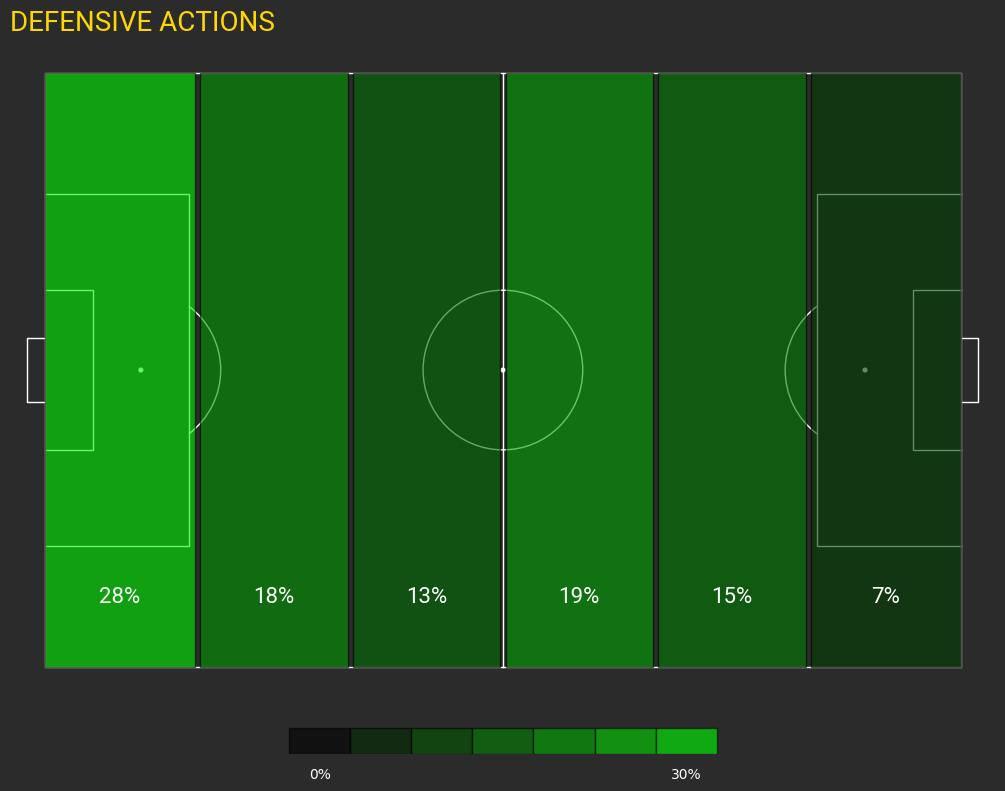

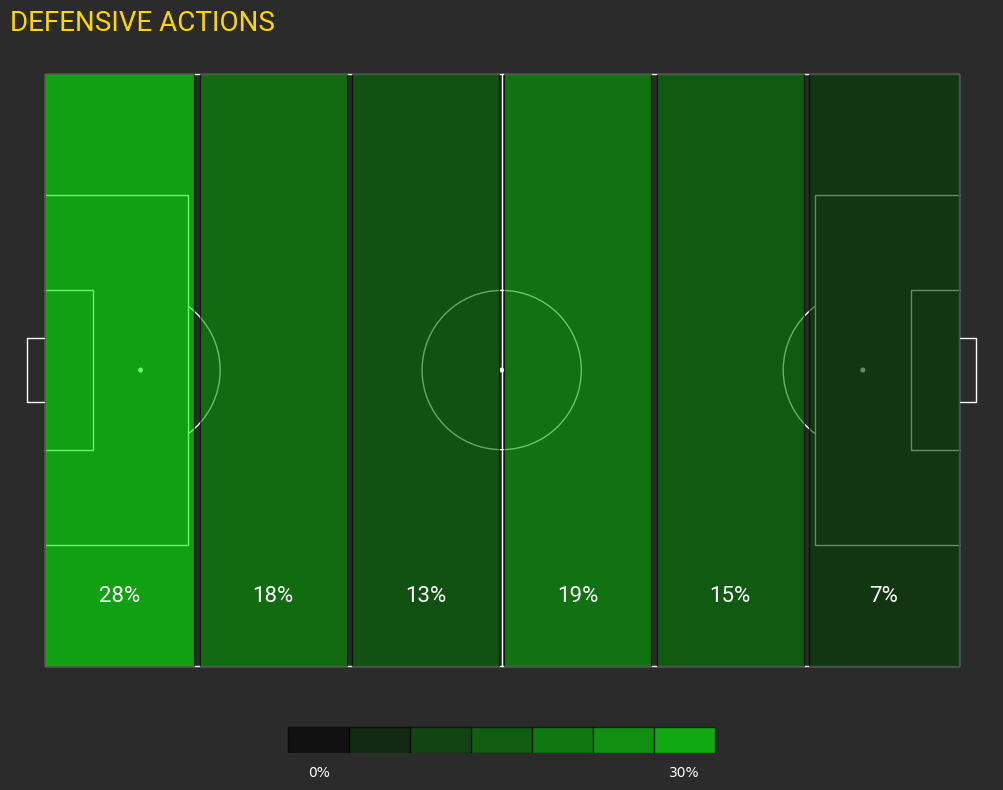

In [288]:
plot_defensive_actions(section_counts_percentage_filt)

# Finally, set-piece data

In [292]:
set_piece_box_deliveries = set_piece_cross_events.copy()

In [293]:
set_piece_box_deliveries.reset_index(drop=True, inplace=True)

In [294]:
## Only interested in crosses that end up in the box
set_piece_box_deliveries = set_piece_box_deliveries[set_piece_box_deliveries['END_X'] >= 88.5]
set_piece_box_deliveries = set_piece_box_deliveries[set_piece_box_deliveries['END_Y'] <= 54.16]
set_piece_box_deliveries = set_piece_box_deliveries[set_piece_box_deliveries['END_Y'] >= 13.84]

In [295]:
## Now, we want to cateogrize each cross as a "near post", "central", or "far post" cross
""" 
If START_Y < 30.34, then:
    - Near post is where END_Y is < 30.34
    - Central is where END_Y is between 30.34 and 37.66
    - Far post is where END_Y is > 37.66

If START_Y > 37.66, then:
    - Near post is where END_Y is > 37.66
    - Central is where END_Y is between 30.34 and 37.66
    - Far post is where END_Y is < 30.34
"""

def classify_cross(row):
    if row['START_Y'] < 32.00:
        if row['END_Y'] < 30.34:
            return 'Near post'
        elif row['END_Y'] > 37.66:
            return 'Far post'
        elif row['END_Y'] >= 30.34 and row['END_Y'] <= 37.66:
            return 'Central'
    elif row['START_Y'] > 36.0:
        if row['END_Y'] > 37.66:
            return 'Near post'
        elif row['END_Y'] < 30.34:
            return 'Far post'
        elif row['END_Y'] >= 30.34 and row['END_Y'] <= 37.66:
            return 'Central'
    else:
        return 'Not Classified'

In [296]:
set_piece_box_deliveries['Cross_end_location'] = "NaN"
set_piece_box_deliveries['Cross_end_location'] = set_piece_box_deliveries.apply(classify_cross, axis=1)

In [298]:
set_piece_box_deliveries['Cross_end_location'].value_counts()

Cross_end_location
Central      5545
Near post    3290
Far post     2084
Name: count, dtype: int64

In [299]:
filter_1st_contacts = set_piece_box_deliveries[['MATCH_ID', 'ACTION_ID']].copy()
filter_1st_contacts['ACTION_ID'] += 1

In [300]:
set_piece_cross_1st_contacts = df_events.merge(filter_1st_contacts, on=['MATCH_ID', 'ACTION_ID'],how='right')

In [301]:
match_ids_to_remove = set_piece_cross_1st_contacts[set_piece_cross_1st_contacts['TEAM_FBREF_ID'].isna()]['MATCH_ID'].values 
action_ids_to_remove = set_piece_cross_1st_contacts[set_piece_cross_1st_contacts['TEAM_FBREF_ID'].isna()]['ACTION_ID'].values

In [302]:
## Remove missing rows!
for i in range(len(match_ids_to_remove)):
    set_piece_cross_1st_contacts = set_piece_cross_1st_contacts[(set_piece_cross_1st_contacts['MATCH_ID'] != match_ids_to_remove[i]) |
                            (set_piece_cross_1st_contacts['ACTION_ID'] != action_ids_to_remove[i])]
    
    set_piece_box_deliveries = set_piece_box_deliveries[(set_piece_box_deliveries['MATCH_ID'] != match_ids_to_remove[i]) |
                            (set_piece_box_deliveries['ACTION_ID'] != action_ids_to_remove[i]-1)]

In [303]:
set_piece_cross_1st_contacts = specify_oppo_team_id_to_events(set_piece_cross_1st_contacts, df_matches)

In [304]:
set_piece_box_deliveries = specify_oppo_team_id_to_events(set_piece_box_deliveries, df_matches)

In [305]:
set_piece_cross_1st_contacts = set_piece_cross_1st_contacts.merge(team_names[['TEAM_NAME', 'TEAM_FBREF_ID']], on="TEAM_FBREF_ID")
set_piece_cross_1st_contacts = set_piece_cross_1st_contacts.merge(team_names_2, on="OPPO_TEAM_ID")

In [306]:
set_piece_box_deliveries = set_piece_box_deliveries.merge(team_names[['TEAM_NAME', 'TEAM_FBREF_ID']], on="TEAM_FBREF_ID")
# set_piece_box_deliveries = set_piece_box_deliveries.merge(team_names_2, on="OPPO_TEAM_ID")

In [307]:
set_piece_cross_1st_contacts.sort_values(by=['MATCH_ID', 'ACTION_ID'], inplace=True)
set_piece_cross_1st_contacts.reset_index(drop=True, inplace=True)

In [308]:
set_piece_box_deliveries.sort_values(by=['MATCH_ID', 'ACTION_ID'], inplace=True)
set_piece_box_deliveries.reset_index(drop=True, inplace=True)

In [309]:
set_piece_cross_1st_contacts['Cross_end_location'] = set_piece_box_deliveries['Cross_end_location']

In [310]:
set_piece_same_1st_contacts = set_piece_cross_1st_contacts[set_piece_box_deliveries.TEAM_FBREF_ID == set_piece_cross_1st_contacts.TEAM_FBREF_ID]
set_piece_other_1st_contacts = set_piece_cross_1st_contacts[set_piece_box_deliveries.TEAM_FBREF_ID != set_piece_cross_1st_contacts.TEAM_FBREF_ID]

In [311]:
def_team_lost_1st_contact = set_piece_same_1st_contacts.groupby(['COMPETITION', 'SEASON', 'OPPO_TEAM_NAME', 
                                                                 'Cross_end_location'])['Cross_end_location'].count()

In [312]:
def_team_won_1st_contact = set_piece_other_1st_contacts.groupby(['COMPETITION', 'SEASON', 'TEAM_NAME', 
                                                                 'Cross_end_location'])['Cross_end_location'].count()

In [211]:
# def_team_lost_1st_contact = set_piece_same_1st_contacts[set_piece_same_1st_contacts['OPPO_TEAM_NAME'] == 'Arsenal']
# def_team_won_1st_contact = set_piece_other_1st_contacts[set_piece_other_1st_contacts['TEAM_NAME'] == 'Arsenal']

In [314]:
def_set_piece_final = (def_team_won_1st_contact/(def_team_lost_1st_contact+def_team_won_1st_contact))*100

In [213]:
# def_set_piece_final = def_team_won_1st_contact.value_counts('Cross_end_location')/ \
# (def_team_won_1st_contact.value_counts('Cross_end_location')+def_team_lost_1st_contact.value_counts('Cross_end_location'))

In [316]:
def_set_piece_final = pd.DataFrame(def_set_piece_final).rename({'Cross_end_location':'PERC_1ST_CONTACT'}, axis=1).reset_index()

In [318]:
def_set_piece_final.rename(columns={'Cross_end_location':'CROSS_END_LOCATION'}, inplace=True)

In [320]:
def_set_piece_final = def_set_piece_final.merge(df_competitions, on=['COMPETITION','SEASON'])

In [322]:
def_set_piece_final.drop(['COMPETITION'], axis=1, inplace=True)

In [167]:
create_table_query = """
CREATE TABLE IF NOT EXISTS TEAM_DEF_SET_PIECE_FIRST_CONTACTS (
    SEASON INT,
    COMPETITION_ACRONYM VARCHAR(255),
    TEAM_NAME VARCHAR(255),
    PERC_1ST_CONTACT FLOAT,
    CROSS_END_LOCATION VARCHAR(255),
    PRIMARY KEY (SEASON, COMPETITION_ACRONYM, TEAM_NAME, CROSS_END_LOCATION)
);
"""

In [168]:
cur.execute(create_table_query)

In [325]:
upsert_to_snowflake("TEAM_DEF_SET_PIECE_FIRST_CONTACTS", def_set_piece_final, ['SEASON', 'COMPETITION_ACRONYM', 'TEAM_NAME',
                                                                            'CROSS_END_LOCATION'])

Upsert completed. 180 rows processed.


In [326]:
def_set_piece_final = fetch_data(cursor, 'SELECT * FROM  GEGENSTATS.RADAR_CHARTS.TEAM_DEF_SET_PIECE_FIRST_CONTACTS')

In [327]:
def_set_piece_final

,SEASON,COMPETITION_ACRONYM,TEAM_NAME,PERC_1ST_CONTACT,CROSS_END_LOCATION
0,2122,EPL,Arsenal,80.000000,Central
1,2122,EPL,Arsenal,53.846154,Far post
2,2122,EPL,Arsenal,67.796610,Near post
3,2122,EPL,Aston Villa,73.504274,Central
4,2122,EPL,Aston Villa,40.000000,Far post
...,...,...,...,...,...
175,2324,EPL,West Ham,38.709677,Far post
176,2324,EPL,West Ham,74.285714,Near post
177,2324,EPL,Wolves,79.746835,Central
178,2324,EPL,Wolves,80.000000,Far post


In [328]:
def_set_piece_final_filt = def_set_piece_final[def_set_piece_final['SEASON'] == season_selected]
def_set_piece_final_filt = def_set_piece_final_filt[def_set_piece_final_filt['COMPETITION_ACRONYM'] == league_selected]
def_set_piece_final_filt = def_set_piece_final_filt[def_set_piece_final_filt['TEAM_NAME'] == 'Arsenal']

In [329]:
def_set_piece_chart = def_set_piece_final_filt[['CROSS_END_LOCATION', 'PERC_1ST_CONTACT']].set_index('CROSS_END_LOCATION')

In [330]:
def_set_piece_chart.loc['Near post'].values[0]

71.428571429

In [331]:
set_piece_same_1st_contacts.groupby(['COMPETITION', 'SEASON', 'OPPO_TEAM_NAME', 
                                                                 'Cross_end_location'])['Cross_end_location'].count()

COMPETITION         SEASON  OPPO_TEAM_NAME  Cross_end_location
ENG-Premier League  2122.0  Arsenal         Central               17
                                            Far post              12
                                            Near post             19
                            Aston Villa     Central               31
                                            Far post              21
                                                                  ..
                    2324.0  West Ham        Far post              19
                                            Near post              9
                            Wolves          Central               16
                                            Far post               3
                                            Near post             15
Name: Cross_end_location, Length: 180, dtype: int64

In [332]:
def_set_piece_final.sort_values(by=['PERC_1ST_CONTACT'], ascending=False).head(40)

,SEASON,COMPETITION_ACRONYM,TEAM_NAME,PERC_1ST_CONTACT,CROSS_END_LOCATION
11,2122,EPL,Brighton,90.789474,Near post
17,2122,EPL,Chelsea,88.461538,Near post
50,2122,EPL,Tottenham,84.375000,Near post
53,2122,EPL,Watford,83.823529,Near post
132,2324,EPL,Brighton,83.673469,Central
71,2223,EPL,Brentford,83.673469,Near post
153,2324,EPL,Luton Town,81.818182,Central
30,2122,EPL,Liverpool,81.818182,Central
77,2223,EPL,Chelsea,81.690141,Near post
8,2122,EPL,Brentford,81.481481,Near post


In [333]:
def create_set_piece_first_contacts_plot(def_set_piece_chart):
    pitch = VerticalPitch(pitch_color='#2B2B2B', line_color='white', goal_type='box', pitch_type='uefa', linewidth=1, half=True)
    fig, ax = pitch.draw(figsize=(8, 12))

    # Define the coordinates for the rectangles
    rect_coords = [
        [(13.84, 105), (13.84, 88.5), (30.09, 88.5), (30.09, 105)],  # Rect1
        [(30.59, 105), (30.59, 88.5), (37.41, 88.5), (37.41, 105)],  # Rect2
        [(37.91, 105), (37.91, 88.5), (54.16, 88.5), (54.16, 105)]  # Rect3
    ]

    # Example percentages for each rectangle (use your actual values here)
    percentages = [def_set_piece_chart.loc['Near post'].values[0], def_set_piece_chart.loc['Central'].values[0], 
                   def_set_piece_chart.loc['Far post'].values[0]]

    # Function to calculate green color based on percentage
    def get_green_color(percentage, max_percentage=100):  # Assuming 100 is the max percentage
        green_intensity = int((percentage / max_percentage) * 255)
        return f'#00{green_intensity:02x}00'

    # Create the rectangular patches
    for i, coords in enumerate(rect_coords):
        polygon = patches.Polygon(coords, closed=True, color="#00b200", zorder=2,  alpha=0.75)
        ax.add_patch(polygon)

        # Add text label in the center of each rectangle
        rect_center_x = (coords[0][0] + coords[2][0]) / 2 
        rect_center_y = (coords[0][1] + coords[2][1]) / 2
        ax.text(rect_center_x, rect_center_y, f'{int(percentages[i])}%',fontproperties='Roboto',
                va='center', ha='center', color='white', fontsize=18, zorder=3)

    # Set figure and axis background color
    fig.patch.set_facecolor('#2B2B2B')
    ax.patch.set_facecolor('#2B2B2B')

    arrow_start = (0, 107)  # Adjust these values as needed for your plot
    arrow_end = (18.84, 107)    # Adjust these values as needed for your plot

    # Draw the arrow
    ax.add_patch(patches.FancyArrow(
        arrow_start[0], arrow_start[1],  # x, y start point
        arrow_end[0] - arrow_start[0], arrow_end[1] - arrow_start[1],  # dx, dy length
        width=0.3,  # Width of the full arrow tail
        length_includes_head=False,  # The head is included in the calculation of the arrow's length
        head_width=1,  # Width of the arrow head
        head_length=1.5,  # Length of the arrow head
        color='lightgrey'  # Light grey color
    ))

    plt.title('SET PIECE FIRST CONTACTS - OWN BOX', color='gold', fontsize=20, fontname='Roboto', loc='left')

    return fig


# pitch = VerticalPitch(pitch_color='#2B2B2B', line_color='white', goal_type='box', pitch_type='uefa', linewidth=1, half=True)
# fig, ax = pitch.draw(figsize=(8, 12))

# # Define the coordinates for the rectangles
# rect_coords = [
#     [(13.84, 105), (13.84, 88.5), (30.09, 88.5), (30.09, 105)],  # Rect1
#     [(30.59, 105), (30.59, 88.5), (37.41, 88.5), (37.41, 105)],  # Rect2
#     [(37.91, 105), (37.91, 88.5), (54.16, 88.5), (54.16, 105)]  # Rect3
# ]

# # Example percentages for each rectangle (use your actual values here)
# percentages = [def_set_piece_chart.loc['Near post'].values[0], def_set_piece_chart.loc['Central'].values[0], 
#                def_set_piece_chart.loc['Far post'].values[0]]

# # Function to calculate green color based on percentage
# def get_green_color(percentage, max_percentage=100):  # Assuming 100 is the max percentage
#     green_intensity = int((percentage / max_percentage) * 255)
#     print(f'#00{green_intensity:02x}00')
#     return f'#00{green_intensity:02x}00'

# # Create the rectangular patches
# for i, coords in enumerate(rect_coords):
#     polygon = patches.Polygon(coords, closed=True, color="#00b200", zorder=2,  alpha=0.75)
#     ax.add_patch(polygon)
    
#     # Add text label in the center of each rectangle
#     rect_center_x = (coords[0][0] + coords[2][0]) / 2 
#     rect_center_y = (coords[0][1] + coords[2][1]) / 2
#     ax.text(rect_center_x, rect_center_y, f'{int(percentages[i])}%',fontproperties='Roboto',
#             va='center', ha='center', color='white', fontsize=18, zorder=3)

# # Set figure and axis background color
# fig.patch.set_facecolor('#2B2B2B')
# ax.patch.set_facecolor('#2B2B2B')

# arrow_start = (0, 107)  # Adjust these values as needed for your plot
# arrow_end = (18.84, 107)    # Adjust these values as needed for your plot

# # Draw the arrow
# ax.add_patch(patches.FancyArrow(
#     arrow_start[0], arrow_start[1],  # x, y start point
#     arrow_end[0] - arrow_start[0], arrow_end[1] - arrow_start[1],  # dx, dy length
#     width=0.3,  # Width of the full arrow tail
#     length_includes_head=False,  # The head is included in the calculation of the arrow's length
#     head_width=1,  # Width of the arrow head
#     head_length=1.5,  # Length of the arrow head
#     color='lightgrey'  # Light grey color
# ))

# plt.title('SET PIECE FIRST CONTACTS - OWN BOX', color='gold', fontsize=20, fontname='Roboto', loc='left')

# plt.show()

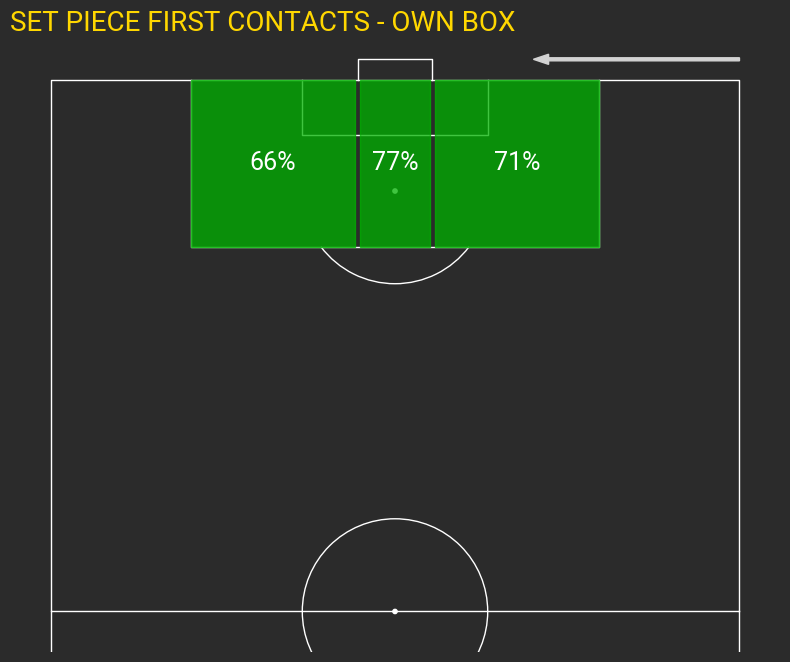

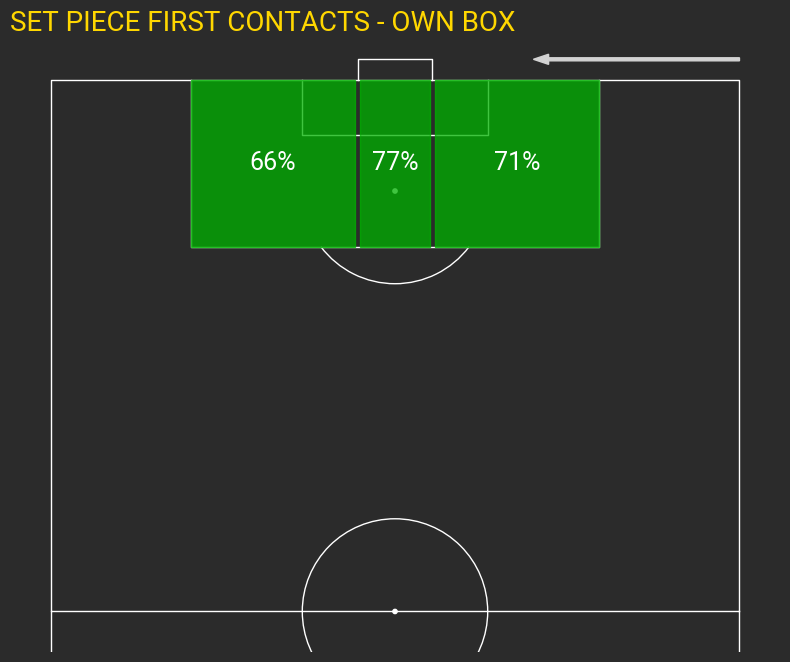

In [334]:
create_set_piece_first_contacts_plot(def_set_piece_chart)

In [335]:
team_attacking.head()

,TEAM_FBREF_ID,SEASON,COMPETITION,GOALS_SCORED,NPXG,XG,SHOTS,SHOTS_ON_TARGET,PASS_COMPLETED,PASS_ATTEMPTED,TAKEONS_ATTEMPTED,TAKEONS_COMPLETED,CROSSES_INTO_PA,FOULS_AGAINST
0,18bb7c10,2122,ENG-Premier League,61,57.19,63.39,581,186,16176,19843,590,319,74,357
1,8602292d,2122,ENG-Premier League,52,40.85,43.13,461,159,12748,16499,587,333,70,504
2,cd051869,2122,ENG-Premier League,48,48.32,52.89,436,141,11676,16272,476,262,81,363
3,d07537b9,2122,ENG-Premier League,42,44.24,49.57,482,141,16410,20588,559,317,72,355
4,943e8050,2122,ENG-Premier League,34,39.58,41.11,405,119,9454,14107,479,258,84,332


In [336]:
attacking_efficiency = team_attacking[['TEAM_FBREF_ID','SEASON','COMPETITION','GOALS_SCORED','SHOTS']]

In [337]:
attacking_efficiency = attacking_efficiency.merge(team_names, on='TEAM_FBREF_ID', how='left')

In [338]:
attacking_efficiency = attacking_efficiency.merge(team_misc[['TEAM_FBREF_ID', 'SEASON', 'COMPETITION','MATCHES_PLAYED']], 
                            on=['TEAM_FBREF_ID', 'SEASON', 'COMPETITION'])

In [339]:
attacking_efficiency['CONVERSION_RATE'] = (attacking_efficiency['GOALS_SCORED'] / attacking_efficiency['SHOTS']) * 100

In [340]:
attacking_efficiency['SHOTS_PER_GAME'] = (attacking_efficiency['SHOTS'] / attacking_efficiency['MATCHES_PLAYED'])

In [341]:
attacking_efficiency

,TEAM_FBREF_ID,SEASON,COMPETITION,GOALS_SCORED,SHOTS,TEAM_NAME,TEAM_LOGO_URL,TEAM_WS_ID,MATCHES_PLAYED,CONVERSION_RATE,SHOTS_PER_GAME
0,18bb7c10,2122,ENG-Premier League,61,581,Arsenal,https://i.imgur.com/SURo5sj.png,13,38,10.499139,15.289474
1,8602292d,2122,ENG-Premier League,52,461,Aston Villa,https://i.imgur.com/M4mwH1X.png,24,38,11.279826,12.131579
2,cd051869,2122,ENG-Premier League,48,436,Brentford,https://i.imgur.com/MOhGOQ4.png,189,38,11.009174,11.473684
3,d07537b9,2122,ENG-Premier League,42,482,Brighton,https://i.imgur.com/EMCwD3X.png,211,38,8.713693,12.684211
4,943e8050,2122,ENG-Premier League,34,405,Burnley,https://i.imgur.com/6IDi9XJ.png,184,38,8.395062,10.657895
5,cff3d9bb,2122,ENG-Premier League,76,583,Chelsea,https://i.imgur.com/6F7h3UR.png,15,38,13.036021,15.342105
6,47c64c55,2122,ENG-Premier League,50,404,Crystal Palace,https://i.imgur.com/LPhzr0K.png,162,38,12.376238,10.631579
7,d3fd31cc,2122,ENG-Premier League,43,430,Everton,https://i.imgur.com/Dgei0uj.png,31,38,10.000000,11.315789
8,5bfb9659,2122,ENG-Premier League,42,480,Leeds United,https://i.imgur.com/2tipH85.png,19,38,8.750000,12.631579
9,a2d435b3,2122,ENG-Premier League,62,433,Leicester City,https://i.imgur.com/ldOUO84.png,14,38,14.318707,11.394737
